
# Basic* LSTM RNN Application: Forecasting Power Consumption

---

```
Arthur Christian L. Cabatingan
12 September 2020
```



**extremely basic*

In [1]:
import sys
sys.path.append('../')
from level2_colors import *

import numpy as np
import pandas as pd 
from functools import reduce

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error

#! pip install keras
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

sns.set_style('whitegrid')
sns.set_palette(colors)

%load_ext autoreload
%autoreload 2

# Load and preprocess data

### Individual household electric power consumption Data Set

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. <br>
Different electrical quantities and some sub-metering values are available</br>

```
Download data: http://archive.ics.uci.edu/ml/machine-learning-databases/00235/
Data dictionary: http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
```

#### Data Set Information:

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France)<br> between December 2006 and November 2010 (47 months).
```
Notes:

1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.
```
#### Attribute Information:
```
1.date: Date in format dd/mm/yyyy
2.time: time in format hh:mm:ss
3.global_active_power: household global minute-averaged active power (in kilowatt)
4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5.voltage: minute-averaged voltage (in volt)
6.global_intensity: household global minute-averaged current intensity (in ampere)
7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.
```

In [2]:
%%time
power_data = pd.read_csv(
    'household_power_consumption.txt', 
    sep=';', 
    parse_dates={'datetime_local' : ['Date', 'Time']}, 
    infer_datetime_format=True, 
    low_memory=False, 
    na_values=['nan','?'], 
    index_col='datetime_local'
)
power_data.columns = [
    'global_active_power', 
    'global_reactive_power', 
    'voltage',
    'global_intensity', 
    'sub_metering_kitchen', 
    'sub_metering_laundry_room',       
    'sub_metering_heater_aircon'
]
print(power_data.columns)
print(power_data.shape)
display(power_data.head())
display(power_data.describe())

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_kitchen', 'sub_metering_laundry_room',
       'sub_metering_heater_aircon'],
      dtype='object')
(2075259, 7)


,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_kitchen,sub_metering_laundry_room,sub_metering_heater_aircon
datetime_local,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_kitchen,sub_metering_laundry_room,sub_metering_heater_aircon
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


CPU times: user 8.78 s, sys: 1.13 s, total: 9.91 s
Wall time: 9.89 s


In [3]:
#Too lazy!
power_data = power_data.sort_index().interpolate()  
power_data.isnull().sum().sum()

0

In [4]:
#Compute other features
power_data['sub_metering_others'] = \
    power_data.global_active_power * (1000/60) \
    - power_data[['sub_metering_kitchen', 
                  'sub_metering_laundry_room',
                  'sub_metering_heater_aircon']
                ].sum(axis=1)

power_data['global_apparent_power'] = \
    power_data.global_active_power \
    + power_data.global_reactive_power

pcols = [
    'global_active_power_kitchen', 
    'global_active_power_laundry_room',
    'global_active_power_heater_aircon', 
    'global_active_power_others'
]
power_data[pcols]= power_data[
    ['sub_metering_kitchen', 
     'sub_metering_laundry_room',
     'sub_metering_heater_aircon', 
     'sub_metering_others']
    ] * (60/1000)

In [5]:
power_data.columns

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_intensity', 'sub_metering_kitchen', 'sub_metering_laundry_room',
       'sub_metering_heater_aircon', 'sub_metering_others',
       'global_apparent_power', 'global_active_power_kitchen',
       'global_active_power_laundry_room', 'global_active_power_heater_aircon',
       'global_active_power_others'],
      dtype='object')

# Exploratory Data Analysis


In [6]:
sm2  = lambda x,y: power_data[x].resample(y).mean()
smm2 = lambda x,y: sm(x,y) - sm(x,y).mean()

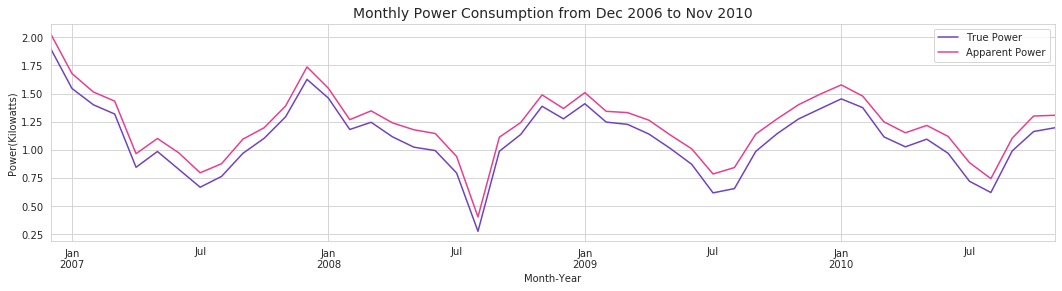

In [7]:
#There seems to be a cycle: consumption goes down during H1, then increases during H2
#Don't know why, work on H1, party on H2? More tourist 2nd half?
plt.figure(figsize=(18,4))
sm2('global_active_power', 'M').plot(label='True Power') 
sm2('global_apparent_power', 'M').plot(label='Apparent Power')
plt.title('Monthly Power Consumption from Dec 2006 to Nov 2010', fontsize=14)
plt.ylabel('Power(Kilowatts)')
plt.xlabel('Month-Year')
plt.legend()
plt.show()

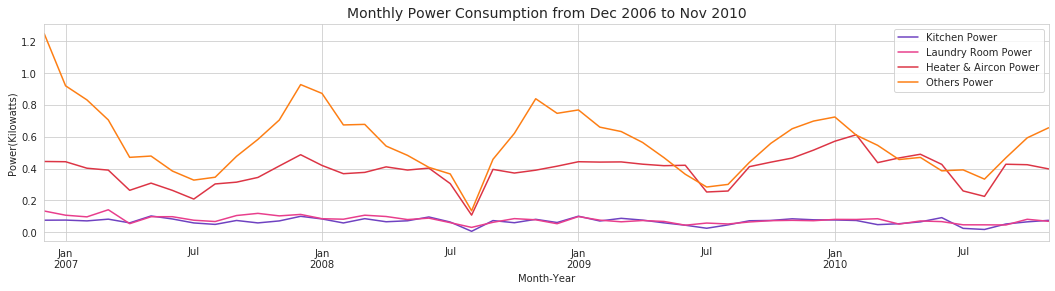

In [8]:
#Others' contributes most (similar trend for everyone, just not ovbious of lower 2)
#Makes sense that Heater & Aircon consumption is higher than Laundry
plt.figure(figsize=(18,4))
sm2('global_active_power_kitchen', 'M').plot(label='Kitchen Power')
sm2('global_active_power_laundry_room', 'M').plot(label='Laundry Room Power')
sm2('global_active_power_heater_aircon', 'M').plot(label='Heater & Aircon Power')
sm2('global_active_power_others', 'M').plot(label='Others Power')
plt.title('Monthly Power Consumption from Dec 2006 to Nov 2010', fontsize=14)
plt.ylabel('Power(Kilowatts)')
plt.xlabel('Month-Year')
plt.legend()
plt.show()

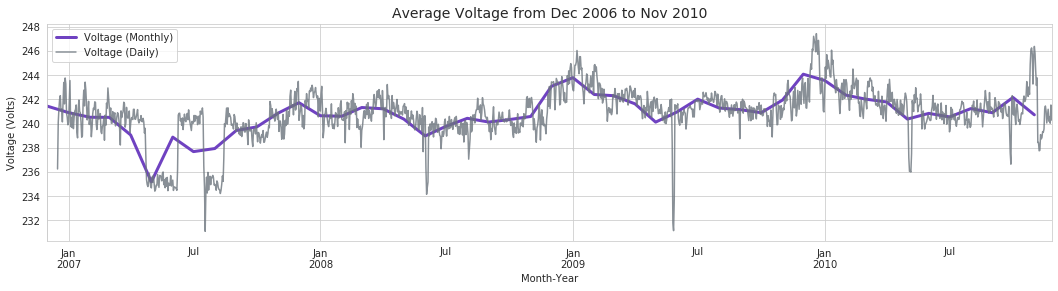

In [9]:
#Showing at different resolution as well: Might not make sense to forcast on daily level.. (our data is at minute level)
plt.figure(figsize=(18,4))
sm2('voltage', 'M').plot(label='Voltage (Monthly)', color=L2['purple'],linewidth=3)
sm2('voltage', 'D').plot(label='Voltage (Daily)', alpha=0.8, color=L2['gray'])
plt.title('Average Voltage from Dec 2006 to Nov 2010', fontsize=14)
plt.ylabel('Voltage (Volts)')
plt.xlabel('Month-Year')
plt.legend()
plt.show()

## Correlations Among Features

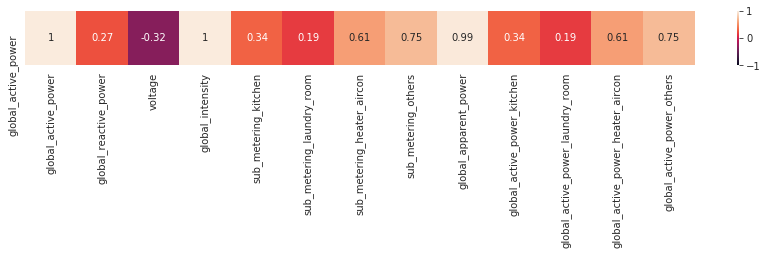

In [10]:
fig = plt.figure(figsize=(15,1))
sns.heatmap(power_data.corr(method='spearman').head(1), 
            vmin=-1, vmax=1, annot=True, cbar=True)

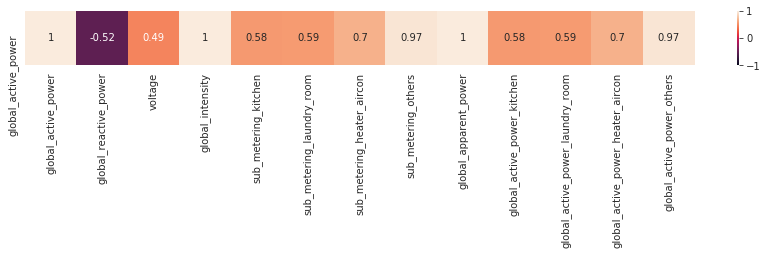

In [11]:
#Correlations changed
fig = plt.figure(figsize=(15,1))
sns.heatmap(power_data.resample('M').mean().corr(method='spearman').head(1), 
            vmin=-1, vmax=1, annot=True, cbar=True)

# LSTM-RNN (predict global_active_power)

- For quick demo purposes only, simplest we can build

## Prep Data

### Choose features, resample, normalize, 

In [12]:
feat_cols = ['global_active_power', 'global_reactive_power', 'voltage', 
    'global_active_power_kitchen', 'global_active_power_laundry_room', 
    'global_active_power_heater_aircon','global_active_power_others'
            ]
power_data2 = power_data[feat_cols]
power_data2 = power_data2.resample('H').mean() 

#Normalize features
scaler = StandardScaler()
scaled = scaler.fit_transform(power_data2)

print(power_data2.columns)
power_data2.head()

Index(['global_active_power', 'global_reactive_power', 'voltage',
       'global_active_power_kitchen', 'global_active_power_laundry_room',
       'global_active_power_heater_aircon', 'global_active_power_others'],
      dtype='object')


,global_active_power,global_reactive_power,voltage,global_active_power_kitchen,global_active_power_laundry_room,global_active_power_heater_aircon,global_active_power_others
datetime_local,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,0.0,0.031667,1.011667,3.179556
2006-12-16 18:00:00,3.632200,0.080033,234.580167,0.0,0.403000,1.012000,2.217200
2006-12-16 19:00:00,3.400233,0.085233,233.232500,0.0,0.086000,1.001000,2.313233
2006-12-16 20:00:00,3.268567,0.075100,234.071500,0.0,0.000000,1.007000,2.261567
2006-12-16 21:00:00,3.056467,0.076667,237.158667,0.0,0.025000,1.033000,1.998467


### Create windows

- Length of input sequence --> 23
- Number of features --> 7
- Stride --> 1

In [13]:
#Create windows (note: data is for one household only)
def windower(iterable, window_size):
    return list(zip(*[iterable[i:] for i in range(window_size)]))

def temp_wrapper(col_name, df=power_data2, time_step=24):
    return pd.Series(
        windower(df[col_name].values,time_step), 
        index=df.index[time_step - 1:]
    ).to_frame(col_name+f'_seq{time_step}')

dfs = [temp_wrapper(c) for c in feat_cols]
df  = reduce(lambda left,right: left.join(right,how='outer'), dfs)
print(df.shape)
df.head()

(34566, 7)


,global_active_power_seq24,global_reactive_power_seq24,voltage_seq24,global_active_power_kitchen_seq24,global_active_power_laundry_room_seq24,global_active_power_heater_aircon_seq24,global_active_power_others_seq24
datetime_local,,,,,,,
2006-12-17 16:00:00,"(4.222888888888891, 3.6322, 3.4002333333333334...","(0.22899999999999995, 0.08003333333333332, 0.0...","(234.6438888888889, 234.58016666666666, 233.23...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.03166666666666667, 0.40299999999999925, 0.0...","(1.011666666666667, 1.0120000000000011, 1.0010...","(3.1795555555555555, 2.2172000000000005, 2.313..."
2006-12-17 17:00:00,"(3.6322, 3.4002333333333334, 3.268566666666666...","(0.08003333333333332, 0.08523333333333337, 0.0...","(234.58016666666666, 233.2325, 234.07149999999...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.40299999999999925, 0.08599999999999994, 0.0...","(1.0120000000000011, 1.001000000000001, 1.0070...","(2.2172000000000005, 2.3132333333333324, 2.261..."
2006-12-17 18:00:00,"(3.4002333333333334, 3.268566666666666, 3.0564...","(0.08523333333333337, 0.0751, 0.07666666666666...","(233.2325, 234.07149999999996, 237.15866666666...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.08599999999999994, 0.0, 0.02500000000000001...","(1.001000000000001, 1.0070000000000012, 1.0330...","(2.3132333333333324, 2.2615666666666674, 1.998..."
2006-12-17 19:00:00,"(3.268566666666666, 3.0564666666666667, 2.2001...","(0.0751, 0.07666666666666669, 0.05616666666666...","(234.07149999999996, 237.15866666666665, 238.7...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.02500000000000001, 0.008, 0.005, 0.028...","(1.0070000000000012, 1.033000000000001, 0.2659...","(2.2615666666666674, 1.998466666666666, 1.9261..."
2006-12-17 20:00:00,"(3.0564666666666667, 2.200133333333334, 2.0616...","(0.07666666666666669, 0.05616666666666668, 0.0...","(237.15866666666665, 238.75999999999996, 240.6...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.02500000000000001, 0.008, 0.005, 0.02800000...","(1.033000000000001, 0.26599999999999996, 0.0, ...","(1.998466666666666, 1.9261333333333337, 2.0566..."


### Transform input, output: LSTM input --> (samples, time_steps, features)

In [14]:
#TODO: mk mr rdble
temp = lambda df,col: df[col].apply(lambda x: x[:-1]).to_frame(col)
data = reduce(lambda left,right: left.join(right,how='outer'), 
              [temp(df, c) for c in df.columns])\
    .sum(axis=1).apply(lambda x: np.reshape(x,(1,23,7))).to_frame('input')
data['output'] = df.global_active_power_seq24.apply(lambda x: x[-1])
data.head()

,input,output
datetime_local,,
2006-12-17 16:00:00,"[[[4.222888888888891, 3.6322, 3.40023333333333...",3.326033
2006-12-17 17:00:00,"[[[3.6322, 3.4002333333333334, 3.2685666666666...",3.406767
2006-12-17 18:00:00,"[[[3.4002333333333334, 3.268566666666666, 3.05...",3.697100
2006-12-17 19:00:00,"[[[3.268566666666666, 3.0564666666666667, 2.20...",2.908400
2006-12-17 20:00:00,"[[[3.0564666666666667, 2.200133333333334, 2.06...",3.361500


In [15]:
np.vstack(data.input.values).shape

(34566, 23, 7)

In [16]:
np.vstack(data.output.values).shape

(34566, 1)

### Split train, test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(    
    np.vstack(data.input.values), 
    np.vstack(data.output.values), 
    test_size=0.6, 
    random_state=8)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 

(13826, 23, 7) (13826, 1) (20740, 23, 7) (20740, 1)


## Model 



### Architecture

In [18]:
%%time
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

CPU times: user 443 ms, sys: 9.13 ms, total: 452 ms
Wall time: 435 ms


### Fit

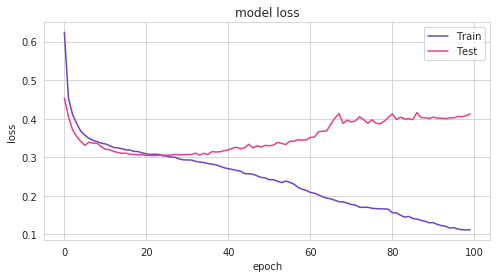

CPU times: user 34min 6s, sys: 7min 6s, total: 41min 13s
Wall time: 12min 13s


In [19]:
%%time
#No GPU
#Fit
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=64, 
    validation_data=(X_test, y_test), 
    verbose=False,
    shuffle=False)

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'])
plt.show()

```1 reason Y early stopping is important```

### Predict

In [20]:
#Predict
y_pred = model.predict(X_test)

#Calculate RMSE (overall)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse) #ngi haha

#TODO Plots

0.6423933807793851


# Notes:

- No hyperparameter tuning
- Basic architecture, we can add CNN layer to learn from local structure of input
- TODO: CGM forecasting (CGM + meds + interventions + steps + sleep + heart_rate + etc)